# ONNX, scikit-learn, persistence, deployment

The notebook explains what ONNX is and how it can be used combined with [sklearn-onnx](https://github.com/onnx/sklearn-onnx) and [onnxruntime](https://github.com/microsoft/onnxruntime). [ONNX](https://onnx.ai/) is a serialization format for machine learning models.

**Xavier Dupré** - Senior Data Scientist at Microsoft - Computer Science Teacher at [ENSAE](http://www.ensae.fr/), [github/xadupre](https://github.com/xadupre), [github/sdpython](https://github.com/sdpython). 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(last_level=2)

In [2]:
import numpy as np
from pyquickhelper.helpgen import NbImage
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from jupytalk.talk_examples.sklearn2019 import (
    graph_persistence_pickle, graph_persistence_pickle_issues,
    graph_persistence_onnx, profile_fct_graph, onnx2str, onnx2dotnb,
    onnxdocstring2html, rename_input_output, graph_three_components)
from mlinsights.plotting import pipeline2dot
%matplotlib inline

In [3]:
from logging import getLogger
logger = getLogger('skl2onnx')
logger.disabled = True

Many functions are implemented in [sklearn2019.py](https://github.com/sdpython/jupytalk/blob/master/src/jupytalk/talk_examples/sklearn2019.py).

## Persistence and predictions

### Persistence with pickle

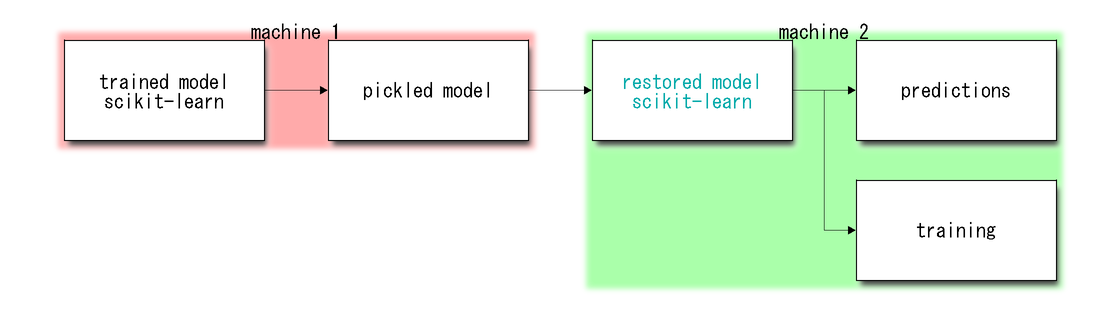

In [4]:
graph_persistence_pickle()

### Main issues

* Unpickle is unstable
* Predictions are not fast (scikit-learn is optimized for batch prediction)

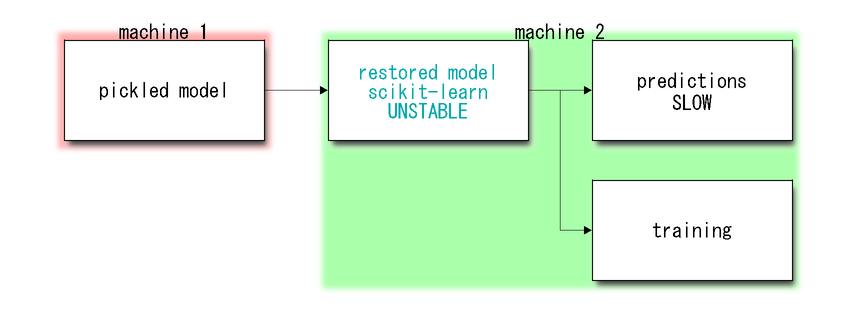

In [5]:
graph_persistence_pickle_issues()

### Iris dataset

In [6]:
data = load_iris()
X, y = data.data, data.target

### Example with logistic regression

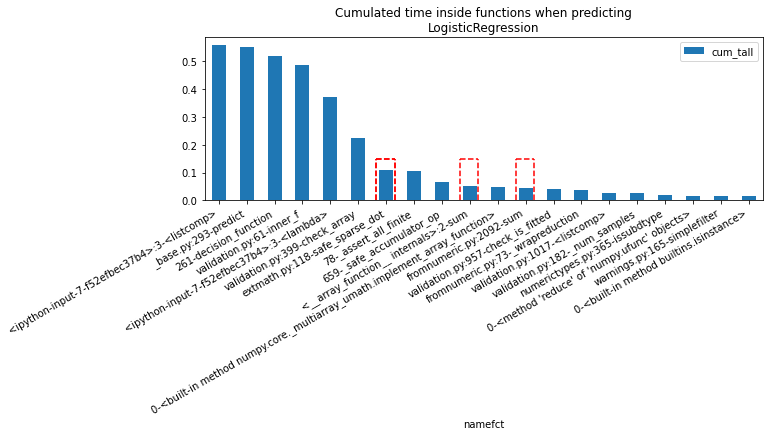

In [7]:
clr = LogisticRegression(multi_class="auto", solver="liblinear").fit(X, y)

profile_fct_graph(lambda: [clr.predict(X) for i in range(0, 1000)],
                  "Cumulated time inside functions when predicting\nLogisticRegression",
                  ["safe_sparse_dot", "dot", "sum"]);

### Persistence with ONNX

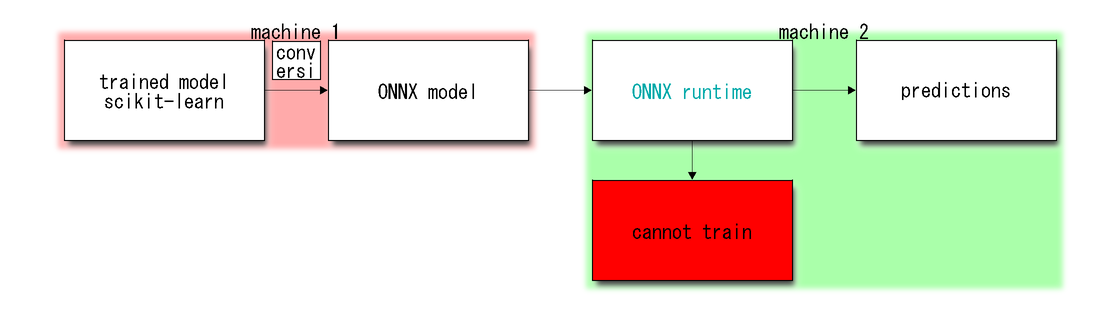

In [8]:
graph_persistence_onnx()

### Three components for ONNX

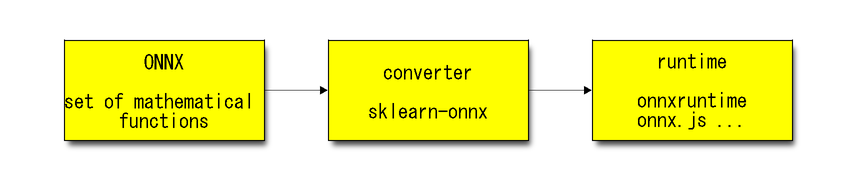

In [9]:
graph_three_components()

## ONNX specifications

* [ONNX](https://onnx.ai/) = **Set of mathematical operations** assembled into a **graph**. 
* It is versioned and **stable**: backward compatibility.
* It is optimized for deep learning, it works with **single float**

### Example with matrix operations

In [10]:
X.shape

(150, 4)

In [11]:
beta = np.random.randn(4, 3)
M = (X @ beta)
expM = np.exp(M)
pred = expM / (expM + 1)
pred[:5]

array([[7.46988595e-01, 7.26135610e-04, 3.21254805e-01],
       [6.97270308e-01, 7.90139722e-04, 3.39865697e-01],
       [7.31365213e-01, 1.25575735e-03, 3.33328901e-01],
       [6.93220419e-01, 1.57934201e-03, 2.58259941e-01],
       [7.56222263e-01, 9.37625385e-04, 2.99774826e-01]])

Conversion to single float

In [12]:
X32 = X.astype(np.float32)
beta32 = beta.astype(np.float32)

Let's write the ONNX function.

In [13]:
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxExp, OnnxAdd, OnnxDiv

onnxExpM = OnnxExp(OnnxMatMul('X', beta32))

cst = np.ones((1, 3), dtype=np.float32)
onnxExpM1 = OnnxAdd(onnxExpM, cst)        # use of broadcasting

onnxPred = OnnxDiv(onnxExpM, onnxExpM1)

Let's convert it to ONNX format:

In [14]:
inputs = {'X': X[:1].astype(np.float32)}

model_onnx = onnxPred.to_onnx(inputs)

print(onnx2str(model_onnx))

ir_version: 4
producer_name: "skl2onnx"
producer_version: "1.7.0"
domain: "ai.onnx"
model_version: 0
graph {
  node {
    input: "X"
    input: "Ma_MatMulcst"
    output: "Ma_Y0"
    name: "Ma_MatMul"
    op_type: "MatMul"
    domain: ""
  }
  node {
...


Let's save it in a file.

In [15]:
with open("model-1.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

Let's load it back into Python

In [16]:
import onnx
model2 = onnx.load("model-1.onnx")

Let's be more visual:

In [17]:
onnx2dotnb(model_onnx, orientation='LR')

### Case of a simple linear regression: dedicated operator

In [18]:
from skl2onnx.algebra.onnx_ops import OnnxLinearRegressor
onnxdocstring2html(OnnxLinearRegressor.__doc__)

In [19]:
lin_reg = OnnxLinearRegressor('input',
                              coefficients=list(beta.ravel().astype(np.float64)),
                              targets=2)

inputs = {'input': X[:1].astype(np.float32)}
try:
    model_onnx = lin_reg.to_onnx(inputs)
except Exception as e:
    print(str(e).split("\n")[0])

Shape inference fails.


In [20]:
from onnxconverter_common.data_types import FloatTensorType

model_onnx = lin_reg.to_onnx(inputs, outputs=[('Yp', FloatTensorType((1, 1)))])

onnx2dotnb(model_onnx, width="80%")

## Conversion to ONNX

Describe the prediction function of a machine learned model with [Onnx Operators](https://github.com/onnx/onnx/blob/master/docs/Operators.md).

### scikit-learn to ONNX: sklearn-onnx

In [21]:
clr = LogisticRegression(multi_class="auto", solver="liblinear").fit(X, y)
clr

LogisticRegression(solver='liblinear')

In [22]:
from skl2onnx import to_onnx

model_onnx = to_onnx(clr, X.astype(np.float32), target_opset=12)

onnx2dotnb(model_onnx)

### Conversion of a pipeline

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline([('pca', PCA(n_components=2)),
                 ('lr', LogisticRegression(multi_class="auto"))])
pipe.fit(X, y)

Pipeline(steps=[('pca', PCA(n_components=2)), ('lr', LogisticRegression())])

In [24]:
model_onnx = to_onnx(pipe, X.astype(np.float32), target_opset=12)

onnx2dotnb(model_onnx, orientation="TB", width="30%")

## Runtime

Compute predictions of a machine learned models based on its [ONNX](https://onnx.ai/) definition.

### onnxruntime

There are [multiple runtimes](https://onnx.ai/supported-tools). For CPU, GPU, ARM, [onnxruntime](https://github.com/microsoft/onnxruntime) is one option.

In [25]:
from onnxruntime import InferenceSession

sess = InferenceSession(model_onnx.SerializeToString())

label, proba = sess.run(None, {'X': X32})
label[:3]

array([0, 0, 0], dtype=int64)

In [26]:
pipe.predict_proba(X32)[:3]

array([[9.81390001e-01, 1.86099916e-02, 7.11872743e-09],
       [9.76009954e-01, 2.39900265e-02, 1.93148667e-08],
       [9.84706803e-01, 1.52931912e-02, 6.28132306e-09]])

In [27]:
proba[:3]

[{0: 0.9813900589942932, 1: 0.018609998747706413, 2: 7.118746925272035e-09},
 {0: 0.9760100245475769, 1: 0.023990022018551826, 2: 1.9314878585419137e-08},
 {0: 0.9847068190574646, 1: 0.015293179079890251, 2: 6.281324793633303e-09}]

In [28]:
pipe.predict_proba(X32)[:3]

array([[9.81390001e-01, 1.86099916e-02, 7.11872743e-09],
       [9.76009954e-01, 2.39900265e-02, 1.93148667e-08],
       [9.84706803e-01, 1.52931912e-02, 6.28132306e-09]])

In [29]:
import pandas
pandas.DataFrame(proba).head()

,0,1,2
0,0.981390,0.018610,7.118747e-09
1,0.976010,0.023990,1.931488e-08
2,0.984707,0.015293,6.281325e-09
3,0.975605,0.024395,2.240644e-08
4,0.983403,0.016597,5.354823e-09


### ONNX.js

[API ONNX.js](https://github.com/microsoft/onnxjs/blob/master/docs/api.md)

The example is not working yet.

In [30]:
clr = LogisticRegression(multi_class="auto", solver="liblinear").fit(X, y)
model_onnx = to_onnx(clr, X[:1].astype(np.float32))

In [31]:
model_js = ("var myarr = new Uint8Array([%s]);" % 
    ",".join(map(lambda x: str(x), model_onnx.SerializeToString())))
model_js[:200] + " ... " + model_js[-20:]

'var myarr = new Uint8Array([8,4,18,8,115,107,108,50,111,110,110,120,26,5,49,46,55,46,48,34,7,97,105,46,111,110,110,120,40,0,50,0,58,229,4,10,141,2,10,1,88,18,5,108,97,98,101,108,18,18,112,114,111,98,9 ... ,1,66,4,10,0,16,9]);'

In [32]:
script = """
%s
var myOnnxSession = new onnx.InferenceSession({ backendHint: 'webgl' });
var inferenceInputs = [ new onnx.Tensor(new Float32Array([5.1, 3.5, 1.4, 0.2]), "float32", [1, 4]) ];

myOnnxSession.loadModel(myarr).then(() => {
    myOnnxSession.run(inferenceInputs).then(output => {
        const outputTensor = output.values().next().value;
        document.getElementById("__ID__").innerHTML = "<p>" + String(outputTensor) + "</p>"
    }).catch(function(err) {
    document.getElementById("__ID__").innerHTML = err.message;
    });
}).catch(function(err) {
    document.getElementById("__ID__").innerHTML = err.message;
});
""" % model_js

In [33]:
from jyquickhelper import RenderJS
jr = RenderJS(script, libs = [dict(path="https://cdn.jsdelivr.net/npm/onnxjs/dist/onnx.min.js",
                                   name="onnx", exports="onnx")])
jr

## Benchmark

### LogisticRegression

In [34]:
clr = LogisticRegression(multi_class="auto", solver="liblinear").fit(X, y)

In [35]:
%timeit clr.predict_proba(X[:1])

103 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
sess = InferenceSession(model_onnx.SerializeToString())
X32 = X.astype(np.float32)
%timeit sess.run(None, {'X': X32[:1]})

24.4 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### RandomForestClassifier

In [37]:
clr = RandomForestClassifier(n_estimators=10).fit(X, y)

In [38]:
%timeit clr.predict_proba(X[:1])

1.22 ms ± 75.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
sess = InferenceSession(model_onnx.SerializeToString())
X32 = X.astype(np.float32)
%timeit sess.run(None, {'X': X32[:1]})

24.8 µs ± 863 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Transfer Learning

Insert an ONNX model into a pipeline.

### OnnxTransformer

In [40]:
pipe = Pipeline([('pca', PCA(n_components=2)),
                 ('lr', LogisticRegression(multi_class="auto"))])
pipe.fit(X, y)
model_onnx = to_onnx(pipe, X[:1].astype(np.float32))

In [41]:
from mlprodict.sklapi import OnnxTransformer
tr = OnnxTransformer(model_onnx.SerializeToString(), output_name="output_probability")
tr.fit()
tr.transform(X)[:5]

,0,1,2
0,0.981390,0.018610,7.118747e-09
1,0.976010,0.023990,1.931488e-08
2,0.984707,0.015293,6.281325e-09
3,0.975605,0.024395,2.240644e-08
4,0.983403,0.016597,5.354823e-09


### Within a pipeline

In [42]:
pipe = Pipeline([('onnx', OnnxTransformer(model_onnx.SerializeToString(), 
                                         output_name="output_probability")),
                 ('lr', LogisticRegression(multi_class="auto"))])
pipe.fit(X, y)
dot = pipeline2dot(pipe, X)

from jyquickhelper import RenderJsDot
RenderJsDot(dot)

## Appendix

### Profile RandomForestClassifier

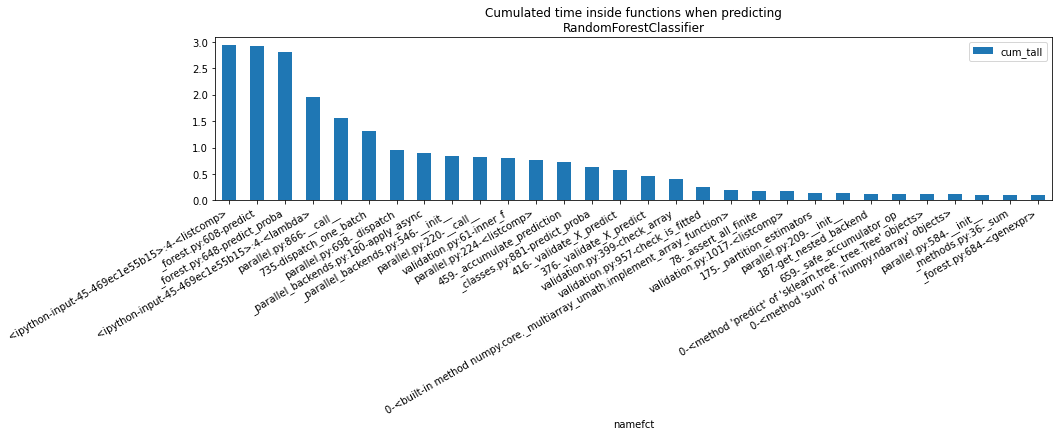

In [43]:
from sklearn.ensemble import RandomForestClassifier
clr = RandomForestClassifier(n_estimators=2).fit(X, y)

profile_fct_graph(lambda: [clr.predict(X) for i in range(0, 1000)], nb=30, figsize=(15, 3),
                  title="Cumulated time inside functions when predicting\nRandomForestClassifier");

### Open source tools in this talk

In [44]:
import onnx, skl2onnx, sklearn, onnxruntime, mlprodict
mods = [onnx, skl2onnx, onnxruntime, sklearn, mlprodict]
for m in mods:
    print(m.__name__, m.__version__)

onnx 1.7.105
skl2onnx 1.7.0
onnxruntime 1.3.993
sklearn 0.24.dev0
mlprodict 0.3.1128
